# Рекомендательная система кинофильмов 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors


In [4]:
movies = pd.read_csv('movies.csv')

star_rating - оценка

title - название фильма 

content_rating  - рейтинг

genre - жанр     

duration - продолжительность   

actors_list - список актёров   

Посмотрим на пять первых строк:

In [10]:
movies.head()

,star_rating,title,content_rating,genre,duration,actors_list
0,9.3,The Shawshank Redemption,R,Crime,142,"[u'Tim Robbins', u'Morgan Freeman', u'Bob Gunt..."
1,9.2,The Godfather,R,Crime,175,"[u'Marlon Brando', u'Al Pacino', u'James Caan']"
2,9.1,The Godfather: Part II,R,Crime,200,"[u'Al Pacino', u'Robert De Niro', u'Robert Duv..."
3,9.0,The Dark Knight,PG-13,Action,152,"[u'Christian Bale', u'Heath Ledger', u'Aaron E..."
4,8.9,Pulp Fiction,R,Crime,154,"[u'John Travolta', u'Uma Thurman', u'Samuel L...."


In [11]:
movies.shape

(979, 6)

Проверим типы данных:

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 6 columns):
star_rating       979 non-null float64
title             979 non-null object
content_rating    976 non-null object
genre             979 non-null object
duration          979 non-null int64
actors_list       979 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 46.0+ KB


Посмотрим пропуски

In [13]:
print(movies.isnull().sum())

star_rating       0
title             0
content_rating    3
genre             0
duration          0
actors_list       0
dtype: int64


Видим, что у 3 фильмов не указан рейтинг. Выведем их:

In [15]:
movies[movies['content_rating'].isnull()].head()

,star_rating,title,content_rating,genre,duration,actors_list
187,8.2,Butch Cassidy and the Sundance Kid,NaN,Biography,110,"[u'Paul Newman', u'Robert Redford', u'Katharin..."
649,7.7,Where Eagles Dare,NaN,Action,158,"[u'Richard Burton', u'Clint Eastwood', u'Mary ..."
936,7.4,True Grit,NaN,Adventure,128,"[u'John Wayne', u'Kim Darby', u'Glen Campbell']"


Удалим эти фильмы из набора данных:

In [16]:
movies = movies[~movies['content_rating'].isnull()]

Выведем гистограмму, чтобы узнать распределение оценок

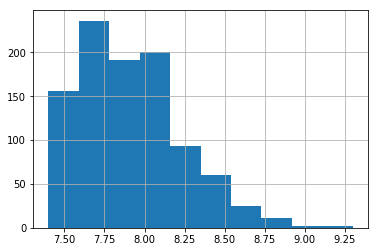

In [23]:
movies["star_rating"].hist();


Посмотрим, как распределились оценки среди фильмов разных жанров:
(используем plt.rcParams['figure.figsize']=(),() чтобы растянуть боксплот и лучше разглядеть названия жанров. так они не сливаются)

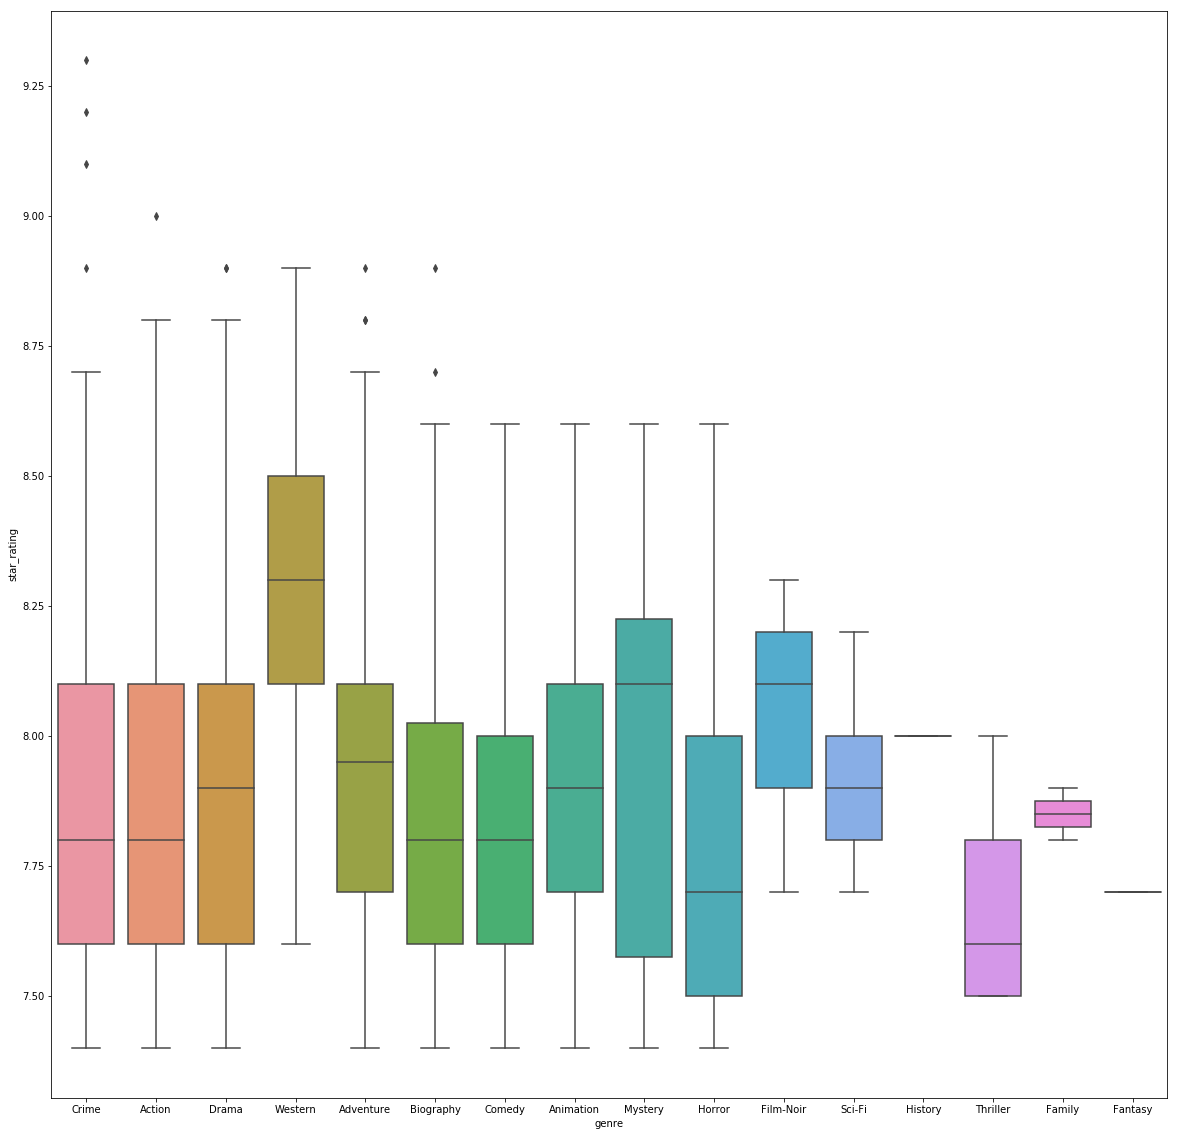

In [32]:
sns.boxplot(data=movies, x='genre', y='star_rating');
plt.rcParams['figure.figsize']=15,20

Интересная информация - выше всего оценены фильмы жанра вестерн

Закодируем жанры и рейтинг (сделаем из строк числа)

In [52]:
movies_features = pd.concat([
    movies["genre"].str.get_dummies(sep=", "),
    movies["actors_list"].str.get_dummies(sep=", "),
    movies[["star_rating"]],
    movies["content_rating"].str.get_dummies(sep=", "),
    movies["duration"]
], axis=1)
movies_features.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,...,NC-17,NOT RATED,PASSED,PG,PG-13,R,TV-MA,UNRATED,X,duration
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,142
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,175
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,200
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,152
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,154


In [53]:
movies_features.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Film-Noir',
       ...
       'NC-17', 'NOT RATED', 'PASSED', 'PG', 'PG-13', 'R', 'TV-MA', 'UNRATED',
       'X', 'duration'],
      dtype='object', length=2221)

Посмотрим минимальное и максимальное значения для оценок и продолжительности

In [54]:
print(movies["star_rating"].min(),'<= star_rating <=',movies["star_rating"].max())
print(movies["duration"].min(),'<= duration <=',movies["duration"].max())

7.4 <= star_rating <= 9.3
64 <= duration <= 242


Масштабируем значения оценок (промежуток [0;1])

In [55]:
min_max_scaler = MinMaxScaler()
movies_features = min_max_scaler.fit_transform(movies_features)

np.round(movies_features, 2)

/home/niyota/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.44],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.62],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.76],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.42],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.28],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.35]])

## Метод К-ближайших соседей (K nearest Neighbor, KNN)

Суть метода заключается в поиске k наиболее похожих объектов на данный при заданной метрике схожести, которой может быть euclidean (Евклидово расстояние), jaccard similarity (коэффициент Жаккара) , minkowsky (метрика Минковского) или произвольная метрика.
Цель - должны находиться 5 фильмов, характеристики которых схожи с характеристиками заданного фильма. Они скорее всего также понравятся пользователю.

In [60]:
def get_index_from_title(title):
    return movies[movies["title"]==title].index.tolist()[0]

def get_id_from_partial_title(partial):
    for title in all_movies_titles:
        if partial in title:
            print(title,all_movies_titles.index(title))

def print_similar_movies(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(movies.iloc[id]["title"])
    if query:
        found_id = get_index_from_title(query)
        for id in indices[found_id][1:]:
            print(movies.iloc[id]["title"])

In [61]:
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(movies_features)
distances, indices = nbrs.kneighbors(movies_features)
all_movies_titles = list(movies.title.values)

Протестируем на моём любимом фильме. Найдём те, которые тоже должны мне понравится

In [67]:
print_similar_movies(query="Star Trek")

The Sound of Music
Planet of the Apes
Ratatouille
Dallas Buyers Club
The Diving Bell and the Butterfly


А теперь выведем все фильмы этой серии, которые есть в датасете

In [63]:
[title for title in movies.title if title.startswith("Star Trek")]

['Star Trek',
 'Star Trek Into Darkness',
 'Star Trek II The Wrath of Khan',
 'Star Trek First Contact']

Продолжаем тестировать

In [69]:
print_similar_movies(query="Titanic")

Sympathy for Lady Vengeance
Road to Perdition
End of Watch
Training Day
Falling Down


In [72]:
[title for title in movies.title if title.startswith("Back to the Future")]

['Back to the Future',
 'Back to the Future Part II',
 'Back to the Future Part III']

In [75]:
print_similar_movies(query="Guardians of the Galaxy")

My Left Foot
12 Years a Slave
The King s Speech
Papillon
Dallas Buyers Club
